In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Lightly adapted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

# SAM 2 - Tự động tạo mask cho đối tượng
# Notebook này hướng dẫn cách sử dụng SAM 2 để tự động tạo mask cho các đối tượng trong ảnh
# mà không cần prompt từ người dùng

# Tự động tạo mask đối tượng với SAM

Vì SAM 2 có thể xử lý prompt một cách hiệu quả, mask cho toàn bộ ảnh có thể được tạo bằng cách lấy mẫu một số lượng lớn prompt trên ảnh.

Lớp `SAM2AutomaticMaskGenerator` triển khai khả năng này. Nó hoạt động bằng cách lấy mẫu các prompt đầu vào một điểm trong lưới trên ảnh, từ mỗi điểm SAM có thể dự đoán nhiều mask. Sau đó, mask được lọc theo chất lượng và loại bỏ trùng lặp bằng non-maximal suppression. Các tùy chọn bổ sung cho phép cải thiện thêm chất lượng và số lượng mask, chẳng hạn như chạy dự đoán trên nhiều crop của ảnh hoặc xử lý hậu kỳ mask để loại bỏ các vùng nhỏ không kết nối và lỗ hổng.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Mở trong Colab"/>
</a>

## Thiết lập môi trường

Nếu chạy cục bộ bằng jupyter, trước tiên hãy cài đặt `SAM 2` trong môi trường của bạn bằng cách làm theo hướng dẫn cài đặt trong repository.

Nếu chạy từ Google Colab, đặt `using_colab=True` bên dưới và chạy cell. Trong Colab, hãy đảm bảo chọn 'GPU' trong 'Edit'->'Notebook Settings'->'Hardware accelerator'. 
Lưu ý rằng nên sử dụng **GPU A100 hoặc L4 khi chạy trong Colab** (GPU T4 cũng có thể hoạt động, nhưng có thể chậm và có thể hết bộ nhớ trong một số trường hợp).

In [ ]:
# Thiết lập biến để xác định có đang chạy trên Google Colab hay không
# Đặt thành True nếu bạn đang chạy trên Google Colab
using_colab = False

In [ ]:
# Cài đặt tự động cho Google Colab
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    
    import sys
    # Cài đặt các thư viện cần thiết
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    # Tạo thư mục và tải ảnh mẫu
    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

    # Tạo thư mục checkpoints và tải model
    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

## Thiết lập

In [ ]:
# Import các thư viện cần thiết
import os
# Nếu sử dụng Apple MPS, fallback về CPU cho các operations không được hỗ trợ
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# Chọn thiết bị để tính toán (GPU/CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

# Tối ưu hóa cho GPU CUDA
if device.type == "cuda":
    # Sử dụng bfloat16 cho toàn bộ notebook để tiết kiệm bộ nhớ
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # Bật tfloat32 cho GPU Ampere (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [ ]:
# Thiết lập seed ngẫu nhiên để đảm bảo kết quả có thể tái tạo
np.random.seed(3)

def show_anns(anns, borders=True):
    """
    Hàm hiển thị các annotation (mask) trên ảnh
    Args:
        anns: Danh sách các annotation
        borders: Có hiển thị đường viền hay không
    """
    if len(anns) == 0:
        return
    # Sắp xếp các annotation theo diện tích từ lớn đến nhỏ
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Tạo ảnh trong suốt để hiển thị mask
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        # Tạo màu ngẫu nhiên cho mỗi mask
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            # Tìm đường viền của mask
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Làm mịn đường viền
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

## Ảnh mẫu

In [ ]:
# Tải ảnh mẫu từ thư mục dữ liệu
# Thay đổi đường dẫn này thành đường dẫn ảnh của bạn
image_path = "../data/raw/bedding/blanket/blanket002.jpg"  # Đường dẫn tương đối

try:
    image = Image.open(image_path)
    image = np.array(image.convert("RGB"))
    print(f"Image loaded successfully: {image.shape}")
except FileNotFoundError:
    print(f"File not found: {image_path}")
    print("Please change the image path in this cell")
    # Tạo ảnh dummy để tránh lỗi
    image = np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8)

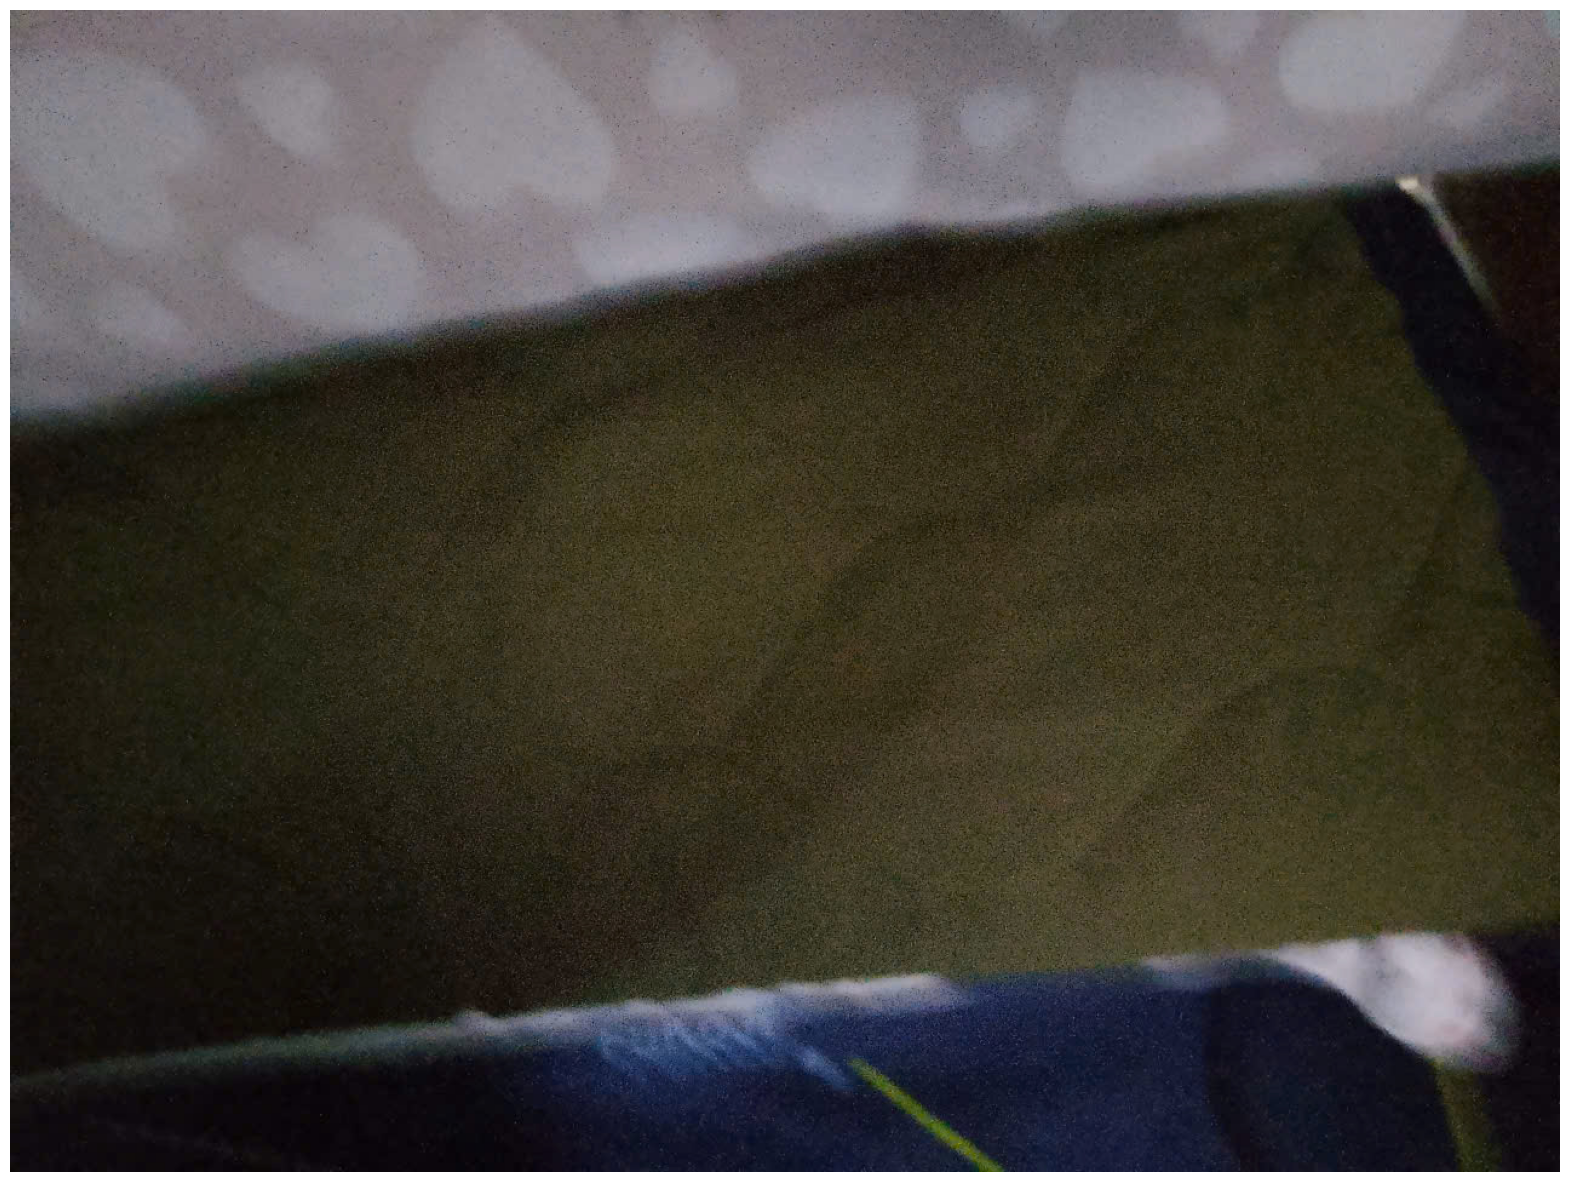

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Tạo mask tự động

Để chạy tạo mask tự động, cung cấp một phiên bản SAM 2 cho lớp `SAM2AutomaticMaskGenerator`. Đặt đường dẫn bên dưới đến checkpoint SAM 2.

In [ ]:
# Tải ảnh bằng OpenCV cho xử lý tiếp theo
import cv2
image_path = "../data/raw/bedding/blanket/blanket003.jpg"  # Đường dẫn tương đối

try:
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image from {image_path}")
    print(f"Image loaded successfully with OpenCV: {image.shape}")
except FileNotFoundError:
    print(f"File not found: {image_path}")
    print("Please change the image path in this cell")
    # Tạo ảnh dummy để tránh lỗi
    image = np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8)

In [ ]:
# Khởi tạo SAM 2 model cho automatic mask generation
import sys
sys.path.append("../sam2")  # Thêm đường dẫn tương đối đến thư mục sam2

from sam2.build_sam import build_sam2

# Đường dẫn đến config và checkpoint
config_file = "../sam2/configs/sam2.1/sam2.1_hiera_l.yaml"
ckpt_path = "../checkpoints/sam2.1_hiera_large.pt"  # Sử dụng model large thay vì l

try:
    sam2_model = build_sam2(
        config_file=config_file,
        ckpt_path=ckpt_path,
        device=device
    )
    print("SAM 2 model initialized successfully!")
except Exception as e:
    print(f"Error initializing SAM 2 model: {e}")
    print("Please check the config and checkpoint paths")


In [ ]:
# Cách khác để khởi tạo SAM 2 model sử dụng Hydra config
# (Cell này có thể bỏ qua nếu cell trước đã hoạt động tốt)
from hydra import initialize_config_dir
import os

# Thư mục chứa file YAML
cfg_dir = "../sam2/configs/sam2.1"
cfg_name = "sam2.1_hiera_l.yaml"   # chỉ tên file, không có path
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"

try:
    with initialize_config_dir(config_dir=cfg_dir, version_base=None):
        sam2 = build_sam2(
            config_file=cfg_name,
            ckpt_path=sam2_checkpoint,
            device=device,
            apply_postprocessing=False
        )
    print("SAM 2 model initialized with Hydra config successfully!")
except Exception as e:
    print(f"Error initializing SAM 2 with Hydra: {e}")
    print("This cell can be skipped if the previous cell worked")


In [ ]:
# Khởi tạo SAM 2 Automatic Mask Generator
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# Đường dẫn đến checkpoint và config
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "../sam2/configs/sam2.1/sam2.1_hiera_l.yaml"

try:
    # Khởi tạo SAM 2 model
    sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)
    
    # Khởi tạo Automatic Mask Generator
    mask_generator = SAM2AutomaticMaskGenerator(sam2)
    print("SAM 2 Automatic Mask Generator initialized successfully!")
    
except Exception as e:
    print(f"Error initializing SAM 2 Automatic Mask Generator: {e}")
    print("Please check the checkpoint and config paths")

Để tạo mask, chỉ cần chạy `generate` trên một ảnh.

In [ ]:
# Tạo mask tự động cho toàn bộ ảnh
# Quá trình này sẽ mất một chút thời gian tùy thuộc vào kích thước ảnh và độ phức tạp
print("Generating masks automatically...")
masks = mask_generator.generate(image)
print(f"Generated {len(masks)} masks")


Tạo mask trả về một danh sách các mask, trong đó mỗi mask là một từ điển chứa các dữ liệu khác nhau về mask. Các khóa này là:
* `segmentation` : mask
* `area` : diện tích của mask tính bằng pixel
* `bbox` : hộp giới hạn của mask ở định dạng XYWH
* `predicted_iou` : dự đoán của chính model về chất lượng của mask
* `point_coords` : điểm đầu vào được lấy mẫu đã tạo ra mask này
* `stability_score` : thước đo bổ sung về chất lượng mask
* `crop_box` : crop của ảnh được sử dụng để tạo mask này ở định dạng XYWH

In [ ]:
print(len(masks))
print(masks[0].keys())

59
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Hiển thị tất cả các mask chồng lên ảnh.

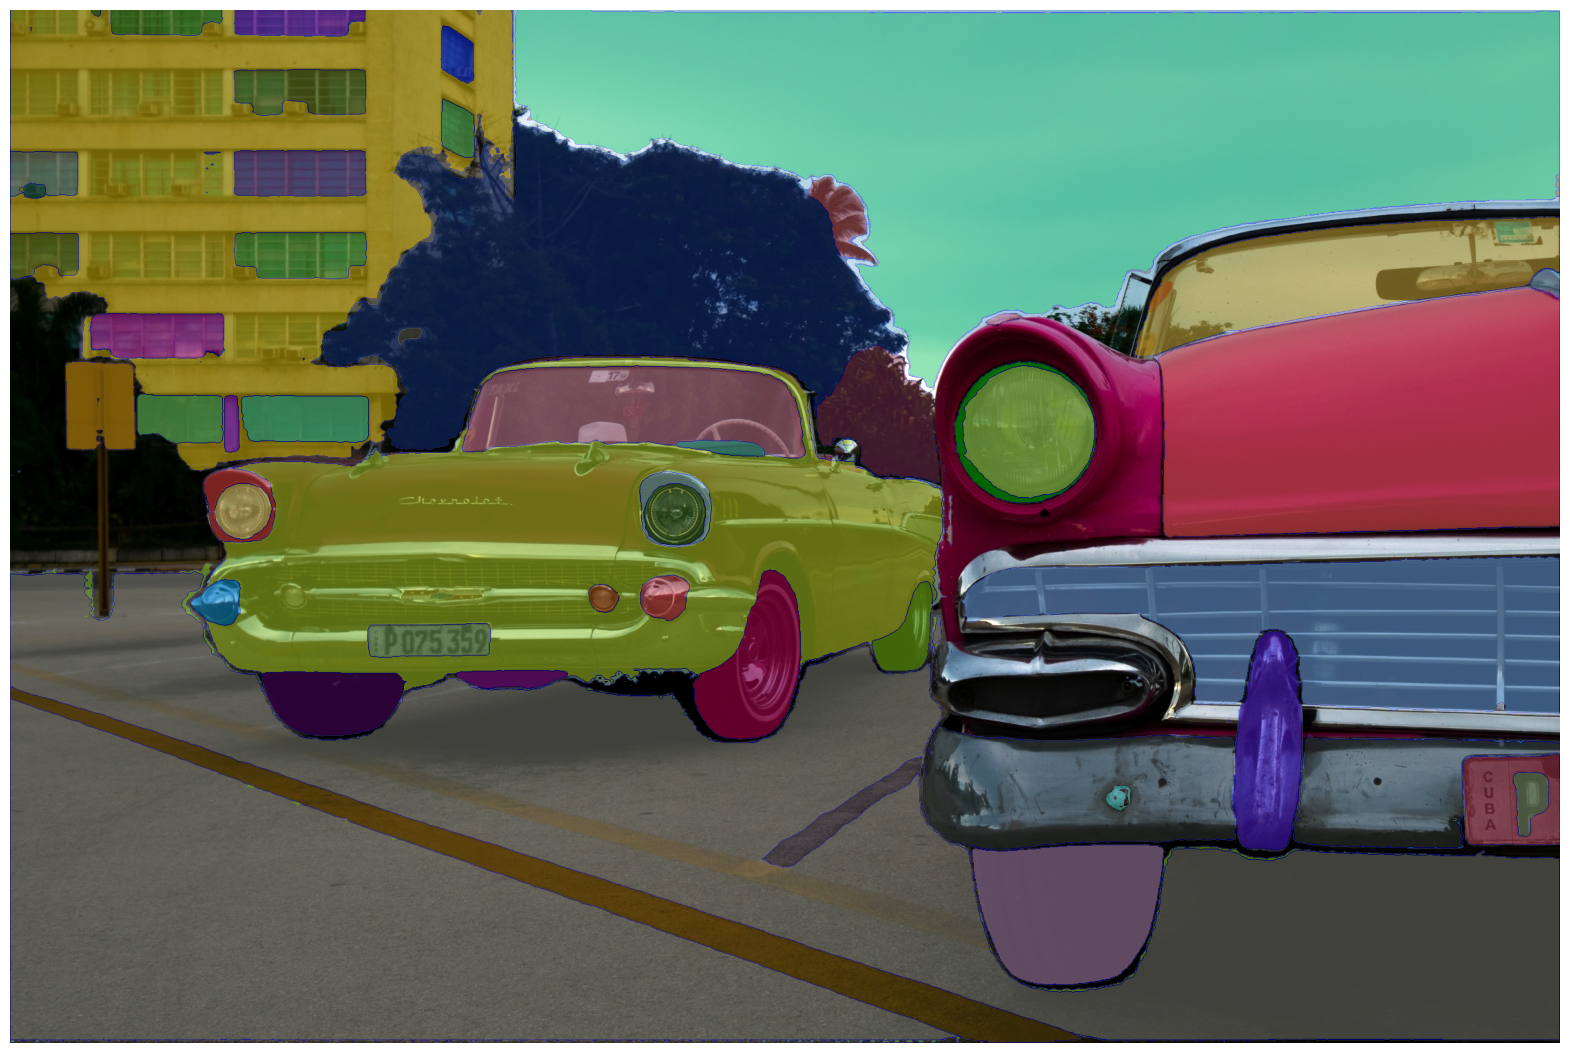

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Tùy chọn tạo mask tự động

### Cấu hình nâng cao cho mask generator

Có một số tham số có thể điều chỉnh trong việc tạo mask tự động để kiểm soát:
- Mật độ lấy mẫu điểm
- Ngưỡng loại bỏ mask chất lượng thấp hoặc trùng lặp
- Chạy dự đoán trên nhiều crop của ảnh để cải thiện hiệu suất trên các đối tượng nhỏ
- Xử lý hậu kỳ để loại bỏ pixel lạc và lỗ hổng

Dưới đây là ví dụ cấu hình lấy mẫu nhiều mask hơn:

In [ ]:
# Cấu hình nâng cao cho mask generator với nhiều tham số tùy chỉnh
# Các tham số này giúp tạo ra nhiều mask hơn và chất lượng tốt hơn
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,                    # Số điểm lấy mẫu trên mỗi cạnh của ảnh
    points_per_batch=128,                   # Số điểm xử lý trong mỗi batch
    pred_iou_thresh=0.7,                   # Ngưỡng IoU để lọc mask chất lượng thấp
    stability_score_thresh=0.92,           # Ngưỡng stability score để lọc mask
    stability_score_offset=0.7,           # Offset cho stability score
    crop_n_layers=1,                      # Số lớp crop để xử lý ảnh
    box_nms_thresh=0.7,                    # Ngưỡng NMS cho bounding box
    crop_n_points_downscale_factor=2,     # Hệ số downscale cho crop
    min_mask_region_area=25.0,            # Diện tích tối thiểu của mask region
    use_m2m=True,                         # Sử dụng mask-to-mask refinement
)

In [ ]:
# Tạo mask với cấu hình nâng cao
# Cấu hình này sẽ tạo ra nhiều mask hơn nhưng có thể mất nhiều thời gian hơn
print("Generating masks with advanced configuration...")
masks2 = mask_generator_2.generate(image)
print(f"Generated {len(masks2)} masks with advanced configuration")

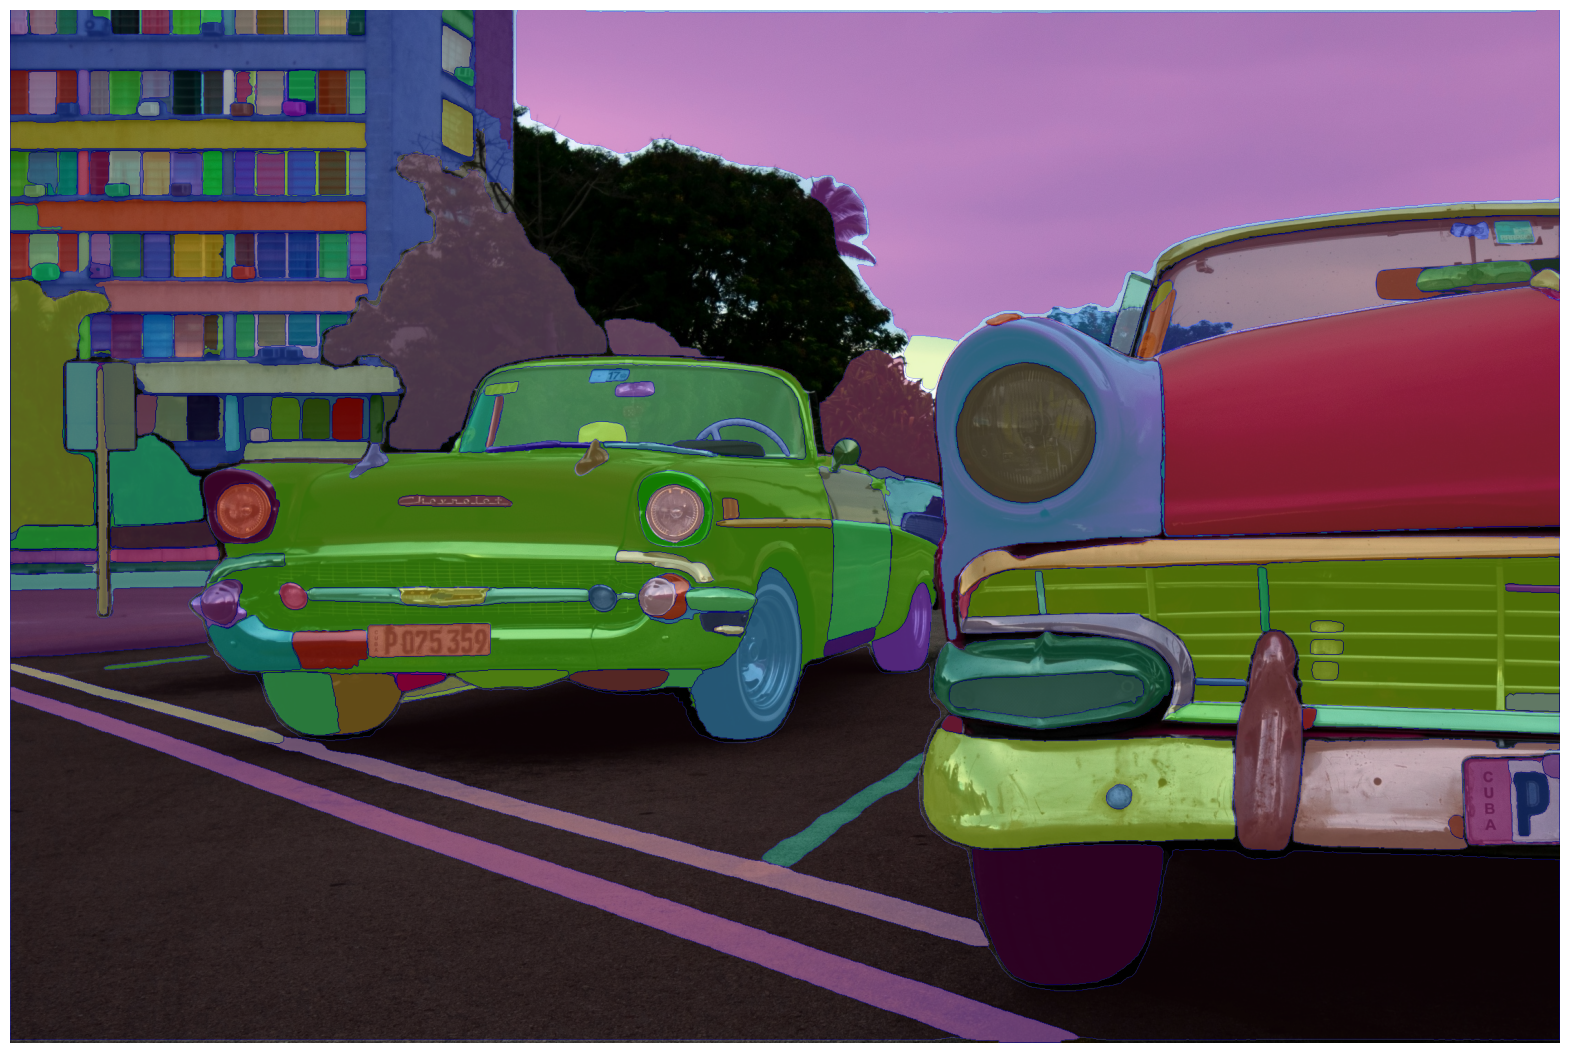

In [15]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 